<a href="https://colab.research.google.com/github/IKAR42/SberDS_Study/blob/main/HW_NN_4_cv_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 400 #changed
out_dim = 20 #changed
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 6 #changed
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset_test[555]

In [19]:
class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.do = nn.Dropout(0.1) #changed
    self.linear3 = nn.Linear(hidden_dim, out_dim) #changed
    
     

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x))) #changed
    x = self.activ(self.do(self.linear2(x))) #changed

    return self.linear3(x)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim) #changed
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear3 = nn.Linear(hidden_dim, out_dim) #changed

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))
    x = self.activ(self.do(self.linear2(x))) #changed

    return self.linear3(x) #changed

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, out_dim)
    self.decoder = Decoder(out_dim, hidden_dim, input_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [ ]:
#model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
#optim = torch.optim.Adam(model.parameters())
#loss_func = nn.MSELoss() #TODO try to use MAE


In [20]:
model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #use MAE

epoch: 0, step: 0, loss: 0.9455633163452148
epoch: 0, step: 200, loss: 0.2595577538013458
epoch: 0, step: 400, loss: 0.218233123421669


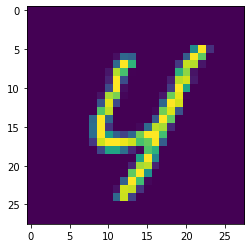

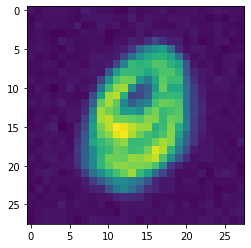

epoch: 1, step: 0, loss: 0.2038947492837906
epoch: 1, step: 200, loss: 0.2021385133266449
epoch: 1, step: 400, loss: 0.18217895925045013


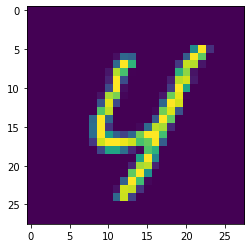

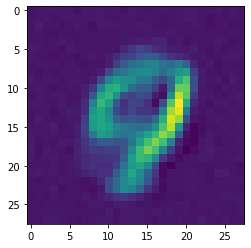

epoch: 2, step: 0, loss: 0.18448016047477722
epoch: 2, step: 200, loss: 0.17373348772525787
epoch: 2, step: 400, loss: 0.1674264520406723


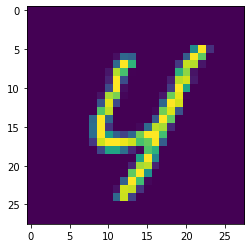

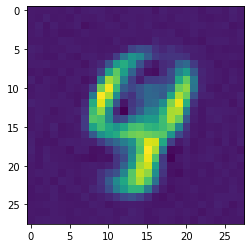

epoch: 3, step: 0, loss: 0.1683603972196579
epoch: 3, step: 200, loss: 0.16808193922042847
epoch: 3, step: 400, loss: 0.1598188877105713


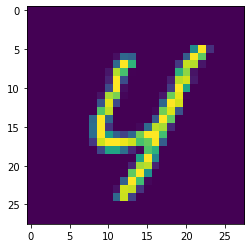

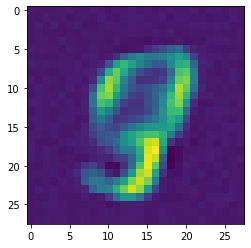

epoch: 4, step: 0, loss: 0.15637053549289703
epoch: 4, step: 200, loss: 0.14866815507411957
epoch: 4, step: 400, loss: 0.15230432152748108


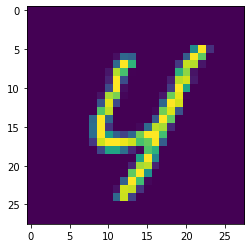

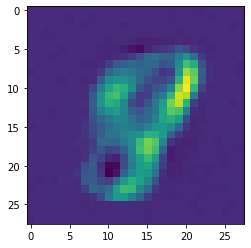

epoch: 5, step: 0, loss: 0.1513241082429886
epoch: 5, step: 200, loss: 0.15371225774288177
epoch: 5, step: 400, loss: 0.14839012920856476


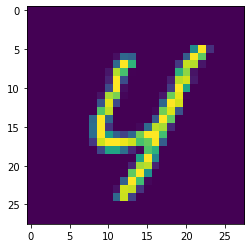

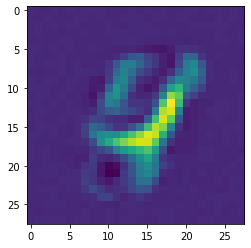

In [21]:
#changed results

# hidden_out = 40
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model(target)
        loss = loss_func(target, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()
    plt.imshow(dataset_test.data[555].detach().numpy())
    plt.show()
    plt.imshow(model(item).view((28, 28)).cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


In [18]:
input_channels = 1
hidden_channels = 64

In [29]:
class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2)
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.conv4 = nn.Conv2d(hidden_ch, 1,kernel_size=3, stride=1, 
                           padding=1) #changed
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.activ(self.conv3(x)) #changed

    return self.conv4(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=5, stride=1,  #changed
                           padding=2)
    self.conv4 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1,  #changed
                           padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.activ(self.conv3(x)) #changed

    return self.conv4(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [ ]:
#model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
#optim = torch.optim.Adam(model.parameters())
#loss_func = nn.MSELoss() #TODO try to use MAE


In [30]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #use MAE

epoch: 0, step: 0, loss: 0.9565888047218323
epoch: 0, step: 200, loss: 0.1747622936964035
epoch: 0, step: 400, loss: 0.13521772623062134


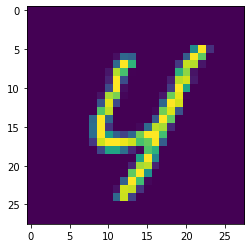

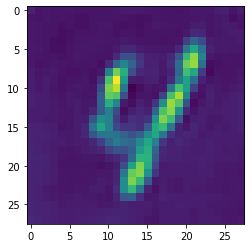

epoch: 1, step: 0, loss: 0.13354803621768951
epoch: 1, step: 200, loss: 0.10905062407255173
epoch: 1, step: 400, loss: 0.09627900272607803


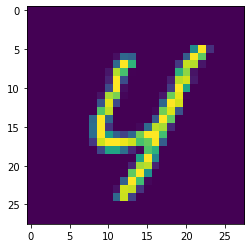

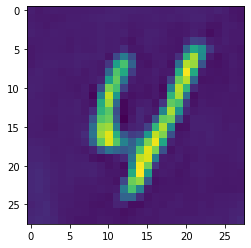

epoch: 2, step: 0, loss: 0.10209321975708008
epoch: 2, step: 200, loss: 0.09267693758010864
epoch: 2, step: 400, loss: 0.09204680472612381


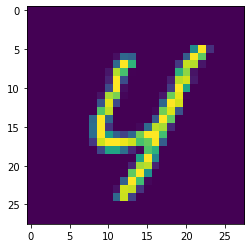

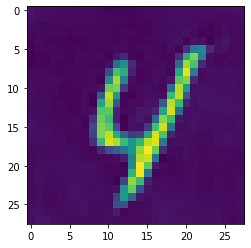

epoch: 3, step: 0, loss: 0.08140221238136292
epoch: 3, step: 200, loss: 0.07968806475400925
epoch: 3, step: 400, loss: 0.07239966094493866


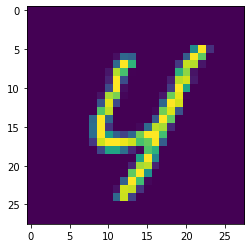

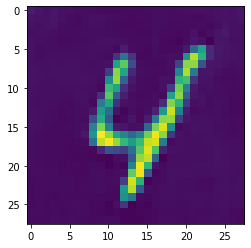

epoch: 4, step: 0, loss: 0.0772213488817215
epoch: 4, step: 200, loss: 0.07630161941051483
epoch: 4, step: 400, loss: 0.06925784796476364


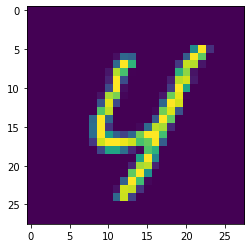

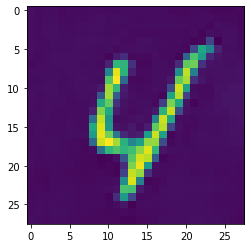

epoch: 5, step: 0, loss: 0.07287754863500595
epoch: 5, step: 200, loss: 0.06982074677944183
epoch: 5, step: 400, loss: 0.06460601091384888


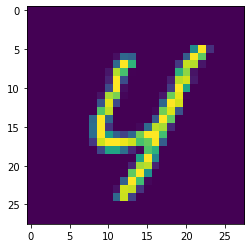

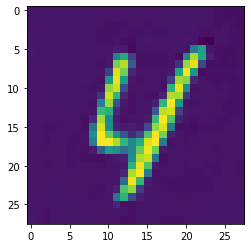

In [31]:
#changed results

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

epoch: 0, step: 0, loss: 0.9482122659683228
epoch: 0, step: 200, loss: 0.19412562251091003
epoch: 0, step: 400, loss: 0.12588107585906982


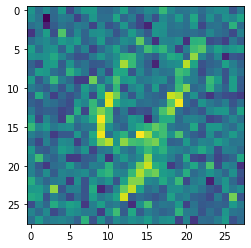

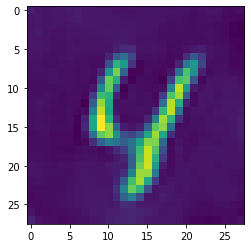

epoch: 1, step: 0, loss: 0.1112859919667244
epoch: 1, step: 200, loss: 0.11343903094530106
epoch: 1, step: 400, loss: 0.09220626950263977


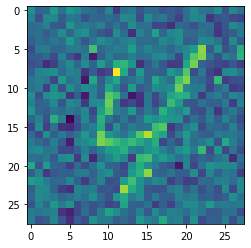

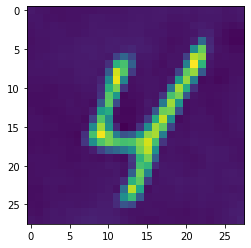

epoch: 2, step: 0, loss: 0.09953422844409943
epoch: 2, step: 200, loss: 0.09012557566165924
epoch: 2, step: 400, loss: 0.10014989227056503


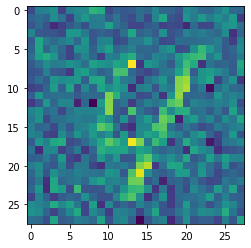

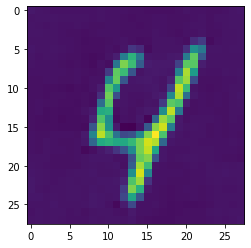

epoch: 3, step: 0, loss: 0.09653659909963608
epoch: 3, step: 200, loss: 0.09125608950853348
epoch: 3, step: 400, loss: 0.09213245660066605


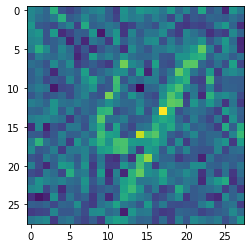

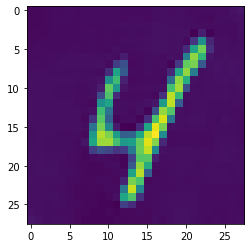

epoch: 4, step: 0, loss: 0.0811304822564125
epoch: 4, step: 200, loss: 0.08019426465034485
epoch: 4, step: 400, loss: 0.07934484630823135


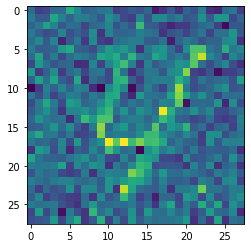

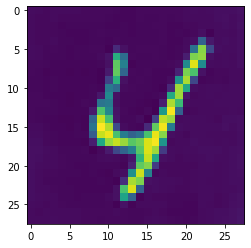

epoch: 5, step: 0, loss: 0.07993941754102707
epoch: 5, step: 200, loss: 0.07725256681442261
epoch: 5, step: 400, loss: 0.07994319498538971


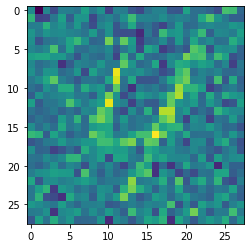

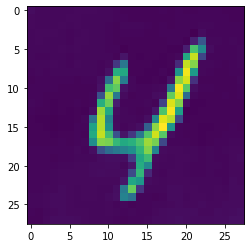

In [32]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
#loss_func = nn.MSELoss() #TODO try to use MAE
loss_func = nn.L1Loss() #use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict = model(noise_inputs)
        loss = loss_func(inputs, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

In [51]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    #self.conv4 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) #changed
    #self.pool4 = nn.MaxPool2d(2, 2) #changed
    #self.do4 = nn.Dropout(0.1) #changed
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))
    #x = self.pool4(self.do4(self.activ(self.conv4(x)))) #changed

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    #self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
    #                       padding=2) #changed
    #self.do3 = nn.Dropout(0.1) #changed
    #self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2) #changed
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    #x = self.upsample3(self.do3(self.activ(self.conv3(x)))) #changed

    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 1.0211079120635986
epoch: 0, step: 200, loss: 0.9464391469955444
epoch: 0, step: 400, loss: 0.9457463026046753


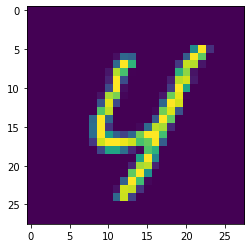

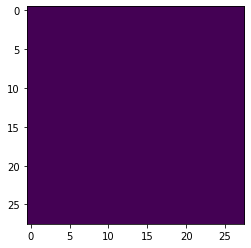

epoch: 1, step: 0, loss: 0.94745272397995
epoch: 1, step: 200, loss: 0.9443417191505432
epoch: 1, step: 400, loss: 0.9453489780426025


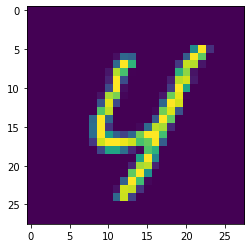

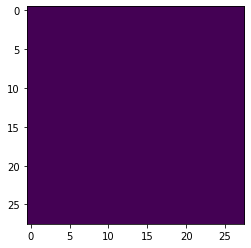

epoch: 2, step: 0, loss: 0.9454061985015869
epoch: 2, step: 200, loss: 0.9433848857879639
epoch: 2, step: 400, loss: 0.9446760416030884


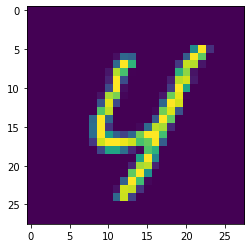

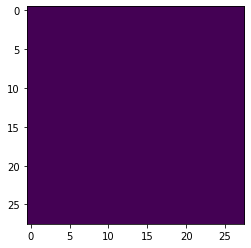

epoch: 3, step: 0, loss: 0.9444583058357239
epoch: 3, step: 200, loss: 0.9447479844093323
epoch: 3, step: 400, loss: 0.9450709819793701


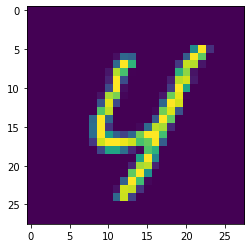

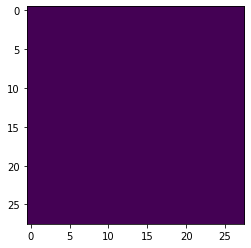

epoch: 4, step: 0, loss: 0.9443245530128479
epoch: 4, step: 200, loss: 0.9450567364692688
epoch: 4, step: 400, loss: 0.9464103579521179


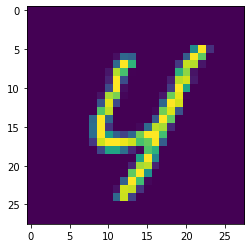

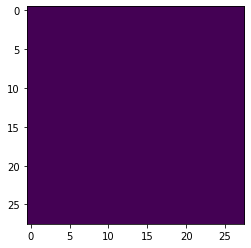

epoch: 5, step: 0, loss: 0.9457451701164246
epoch: 5, step: 200, loss: 0.9447159767150879
epoch: 5, step: 400, loss: 0.945857584476471


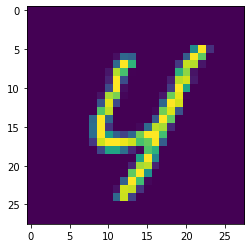

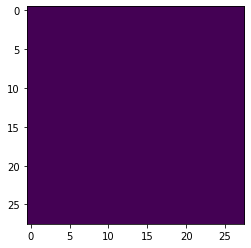

In [52]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
#loss_func = nn.MSELoss() #TODO try to use MAE
loss_func = nn.L1Loss() #use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

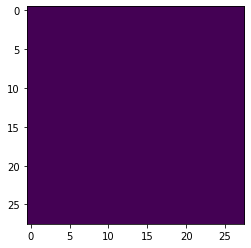

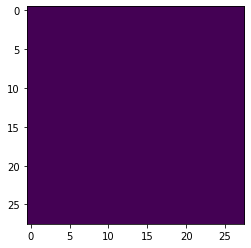

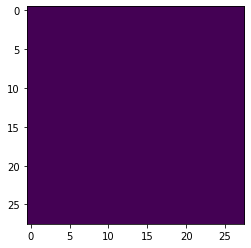

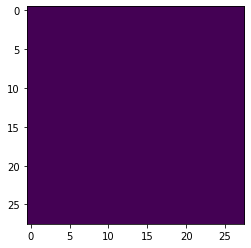

In [54]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(4):
    hid = torch.normal(torch.zeros((1,1,7,7)), torch.ones((1,1,7,7))).to(device) 

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()